# Generating h3 Hexgrids from GeoDataFrames with Popgetter

This example is adapted from the [tobler example](https://nbviewer.org/github/pysal/tobler/blob/main/notebooks/census_to_hexgrid.ipynb) with Popgetter being used instead of `cenpy` to retrieve census data.


In [1]:
# Install requirements first with e.g.:
# `pip install -r requirements.txt`

In [2]:
import geopandas  as gpd
import matplotlib.pyplot as plt
import pandas
import libpysal
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import contextily as ctx
from cenpy import products
import popgetter
from shapely import wkt

/Users/sgreenbury/Projects/ua2/popgetter/popgetter_py/notebooks/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Getting data with Popgetter


To begin with, we will fetch some data with popgetter using the two functions below:
- `from_text` (generates search params from regex text)
- `from_ids` (searches for a list of metric IDs)

We're looking for median home value, so first we will filter the ACS tables by those containing "Median Value" in the description so we can find the correct variable code


In [3]:

def from_text(text: str, country="USA", geometry_level="tract", year=2019) -> dict:
    return {
        "metric_id": [],
        "text": [{
        "text": text,
        "context": ["Hxl", "HumanReadableName", "Description"],
        "config": {"match_type": "Regex", "case_sensitivity": "Insensitive"}
        }],
        "geometry_level": {
        "value": geometry_level,
        "config": {"match_type": "Exact", "case_sensitivity": "Insensitive"}
        },
        "year_range": [{"Between": [year, year]}],
        "country": {
        "value": country,
        "config": {"match_type": "Regex", "case_sensitivity": "Insensitive"}
        },
        "region_spec": []
    }

def from_ids(ids: list[str]) -> dict:
    return {
        "metric_id": [{"id":id} for id in ids],
        "text":[],
        "region_spec": []
    }

In [4]:
# Search popgetter for "Median Value"
popgetter.search(from_text("Median Value")).head()

Argument is 'dict', searching as search parameters: {'metric_id': [], 'text': [{'text': 'Median Value', 'context': ['Hxl', 'HumanReadableName', 'Description'], 'config': {'match_type': 'Regex', 'case_sensitivity': 'Insensitive'}}], 'geometry_level': {'value': 'tract', 'config': {'match_type': 'Exact', 'case_sensitivity': 'Insensitive'}}, 'year_range': [{'Between': [2019, 2019]}], 'country': {'value': 'USA', 'config': {'match_type': 'Regex', 'case_sensitivity': 'Insensitive'}}, 'region_spec': []}


metric_id,metric_human_readable_name,metric_description,metric_hxl_tag,source_data_release_collection_period_start,country_name_short_en,geometry_level
str,str,str,str,date,str,str
"""fa66317e485ad4d03669286e964072…","""Median value --, Median Value …","""Key: tableID, Value: B25107; K…","""#MedianValue+Total+Total""",2019-01-01,"""United States""","""tract"""
"""33fca6f13bf1f8930ec95cef6d59d4…","""Median value --, Median Value …","""Key: tableID, Value: B25107; K…","""#MedianValue+Total+Total+Built…",2019-01-01,"""United States""","""tract"""
"""7b16ec12053faef76a82f781219bef…","""Median value --, Median Value …","""Key: tableID, Value: B25107; K…","""#MedianValue+Total+Total+Built…",2019-01-01,"""United States""","""tract"""
"""072a0431b85f14ea0a6cb5a867d43e…","""Median value --, Median Value …","""Key: tableID, Value: B25107; K…","""#MedianValue+Total+Total+Built…",2019-01-01,"""United States""","""tract"""
"""83981228a2e870626744aba4e01be4…","""Median value --, Median Value …","""Key: tableID, Value: B25107; K…","""#MedianValue+Total+Total+Built…",2019-01-01,"""United States""","""tract"""


In [5]:
# Search with a single ID and convert to pandas
popgetter.search(from_ids(["fa66317e485ad4d03669286e964072"])).to_pandas().T

Argument is 'dict', searching as search parameters: {'metric_id': [{'id': 'fa66317e485ad4d03669286e964072'}], 'text': [], 'region_spec': []}


,0
metric_id,fa66317e485ad4d03669286e96407281e80947f91c29b6...
metric_human_readable_name,"Median value --, Median Value By Year Structur..."
metric_description,"Key: tableID, Value: B25107; Key: uniqueID, Va..."
metric_hxl_tag,#MedianValue+Total+Total
source_data_release_collection_period_start,2019-01-01 00:00:00
country_name_short_en,United States
geometry_level,tract


In [6]:
# Download a data request with bounding box
data_request_spec = {
  "region": [
    {"BoundingBox": [-74.251785, 40.647043, -73.673286, 40.91014]}
  ],
  "metrics": [
    {"MetricId": {"id": "fa66317e"}},
  ]
}
data = popgetter.download_data_request(data_request_spec).to_pandas()
data.head()

,GEO_ID,geometry,B25107_E001
0,1400000US34003003402,"POLYGON((-74.010455 40.914168,-74.008518999999...",405400
1,1400000US34003004001,"POLYGON((-74.03978599999999 40.879109,-74.0359...",331700
2,1400000US34003004002,"POLYGON((-74.03627399999999 40.879097,-74.0343...",337900
3,1400000US34003005000,POLYGON((-74.10276999999999 40.841477999999995...,408600
4,1400000US34003006100,"POLYGON((-73.994912 40.826245,-73.993505 40.82...",421800


In [7]:
gdf = gpd.GeoDataFrame(data)
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gdf.set_geometry('geometry', crs="EPSG:4326")
dc = gdf.to_crs(crs="EPSG:3587")

In [8]:
dc.head()

,GEO_ID,geometry,B25107_E001
0,1400000US34003003402,"POLYGON ((6872106.346 -211420.862, 6872204.159...",405400
1,1400000US34003004001,"POLYGON ((6870145.267 -215606.712, 6870419.03 ...",331700
2,1400000US34003004002,"POLYGON ((6870439.757 -215570.354, 6870627.475...",337900
3,1400000US34003005000,"POLYGON ((6865395.346 -220435.826, 6865505.407...",408600
4,1400000US34003006100,"POLYGON ((6874656.228 -220960.901, 6874749.827...",421800


## Creating Hexgrids with the `h3fy` function


Using the `h3fy` function from the `tobler.util` module, we can easily generate a hexgrid for the downloaded area.


In [9]:
dc_hex = h3fy(dc, resolution=7)

/Users/sgreenbury/Projects/ua2/popgetter/popgetter_py/notebooks/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


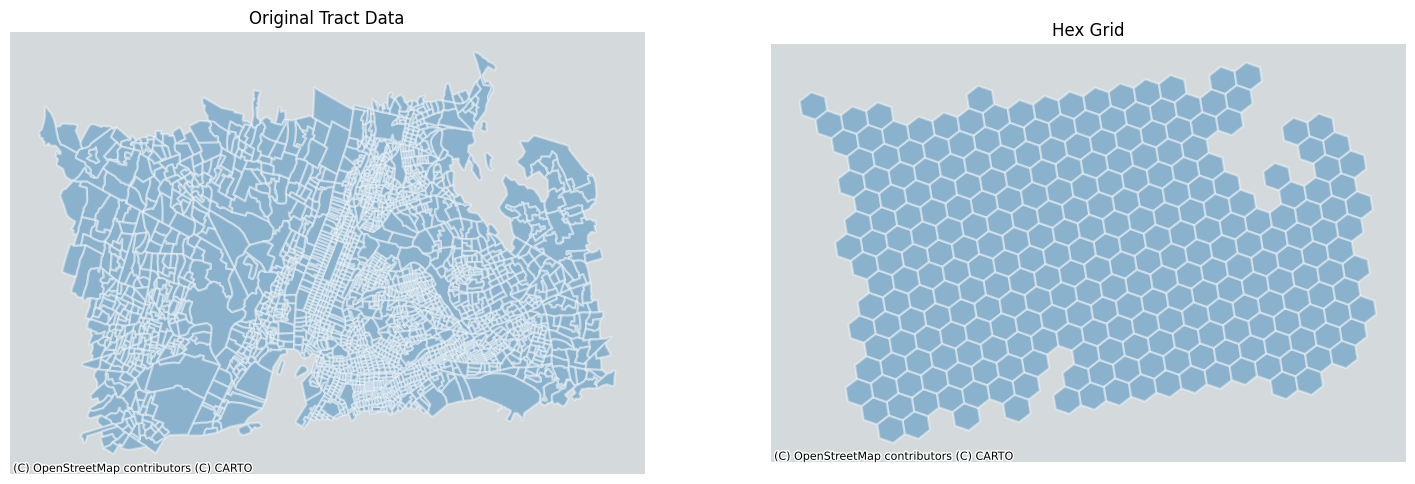

In [10]:

fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()
source = ctx.providers.CartoDB.Positron
dc.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
dc_hex.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor='white')

axs[0].set_title('Original Tract Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    ctx.add_basemap(axs[i], source=source)
    axs[i].axis('off')

By altering the `resolution` parameter, we can generate grids using hexes of various sizes


In [11]:
dc_hex_large = h3fy(dc, resolution=5)
dc_hex_small = h3fy(dc, resolution=7)

/Users/sgreenbury/Projects/ua2/popgetter/popgetter_py/notebooks/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/Users/sgreenbury/Projects/ua2/popgetter/popgetter_py/notebooks/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


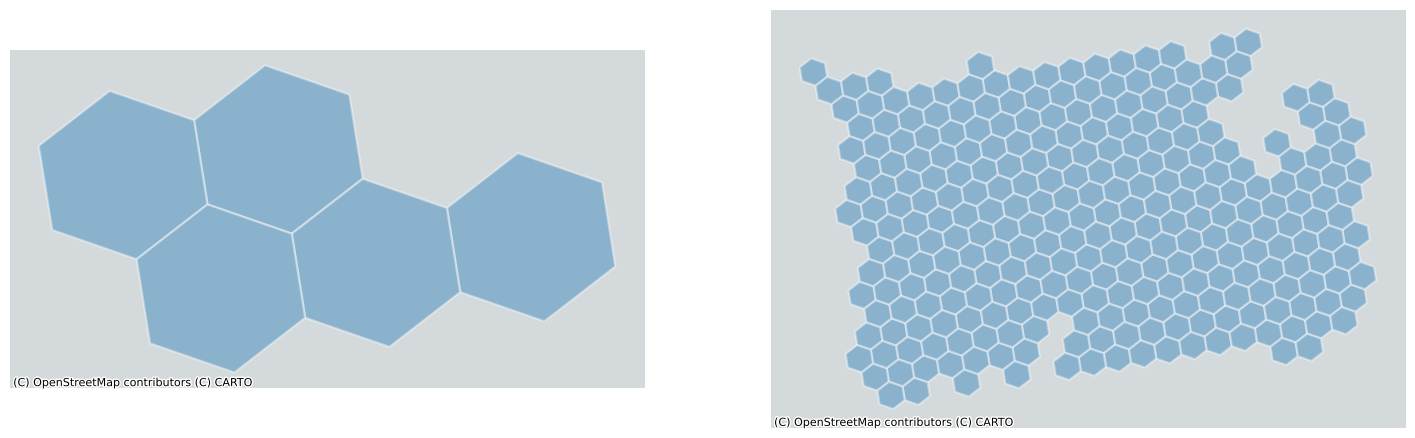

In [12]:

fig, axs = plt.subplots(1,2, figsize=(18,10))

dc_hex_large.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
dc_hex_small.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor='white')

for ax in axs:
    ctx.add_basemap(ax=ax, source=source)
    ax.axis('off')

and by using the `clip` parameter, we can ensure that the hexgrid is does not extend beyond the borders of the input geodataframe


In [13]:
dc_hex_clipped = h3fy(dc.to_crs(epsg="4326"), resolution=6, clip=True)

/Users/sgreenbury/Projects/ua2/popgetter/popgetter_py/notebooks/.venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


(np.float64(-74.31371999999999),
 np.float64(-73.621754),
 np.float64(40.610788108090375),
 np.float64(40.956938090090915))

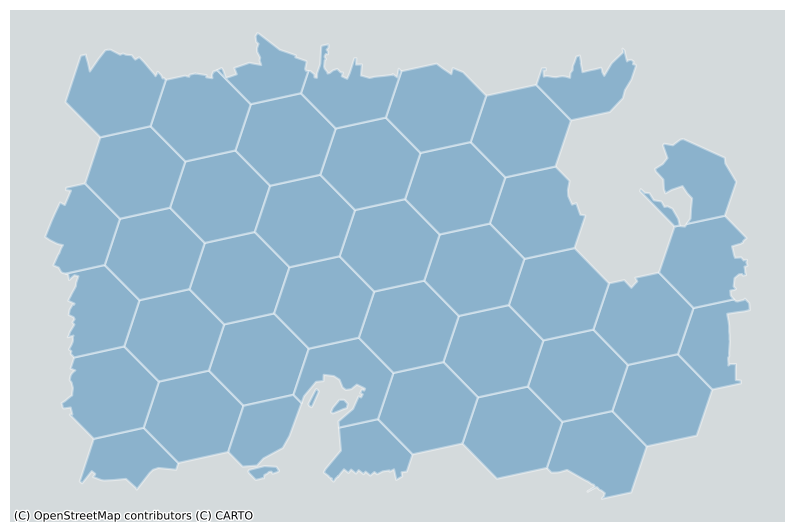

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

dc_hex_clipped.plot(ax=ax, alpha=0.4, linewidth=1.6, edgecolor='white')
ctx.add_basemap(ax=ax, source=source)
ax.axis('off')

## Interpolating to a hexgrid


Thus, in just a few lines of code, we can estimate the value of census variables represented by a regular hexgrid


here, we will estimate the median home value of each hex in the DC region using simple areal interpolation


In [15]:
# col_name = 'B25077_E001'
col_name = 'B25107_E001'
dc_hex_interpolated = area_interpolate(source_df=dc, target_df=dc_hex, intensive_variables=[col_name])

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/gk/g0jp30017pjgv4tqtm955ddr0000gr/T/ipykernel_71999/3242305861.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle('Spatial Interpolation with the PySAL $\mathtt{tobler}$ package with Popgetter', fontsize=16)


Text(0.5, 0.98, 'Spatial Interpolation with the PySAL $\\mathtt{tobler}$ package with Popgetter')

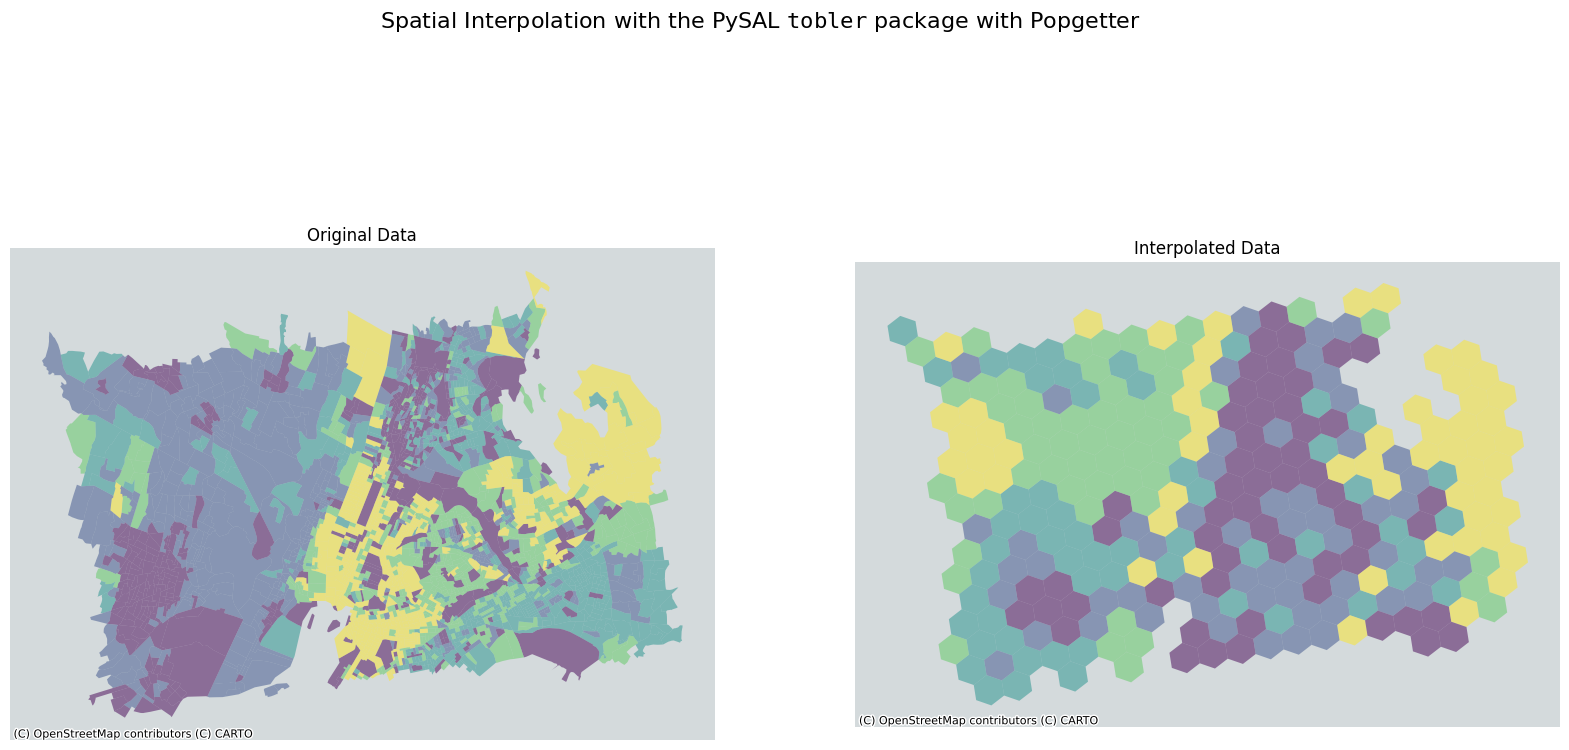

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
dc.plot(col_name, scheme='quantiles', alpha=0.5, ax=axs[0])

dc_hex_interpolated.plot(col_name, scheme='quantiles', alpha=0.5, ax=axs[1])

axs[0].set_title('Original Data')
axs[1].set_title('Interpolated Data')
           
for ax in axs:
    ctx.add_basemap(ax=ax, source=source)
    ax.axis('off')
plt.suptitle('Spatial Interpolation with the PySAL $\mathtt{tobler}$ package with Popgetter', fontsize=16)

### Next steps

- Search and download data for a different metric from the USA census
- Download data from a different Bounding Box
- Search, download and plot data for a different country